In [2]:
import sys
sys.path.append('/Volumes/Sargart/CornellTechWork/IntelAutoSys/Intelligent-Autonomous-System/Project4/ECE5242Proj4') # IMPORTANT TO CHANGE

from maze import *
from evaluation import *
import os
import numpy as np

import cv2
import torch
import pyglet
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gymnasium as gym
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle




# Policy Iteration / Value Iteration

**Notes from Office Hours** 
The code for cell 2 doesn't differentiate the robot when it has no flags vs when it has 1 or more flags which would define the best direction the robot should take. 

Its not just about where the robot is but its about where the robot is and how many flags it has because currently the plot is displaying arrows that just doesn't make sense as to why the robot would go that direction. 

In [3]:
# Cell 1: This calculates the Q-table by implementing value iteration 

def generate_idx2cell(width, height):
    idx2cell = {}
    idx = 0
    for y in range(height):
        for x in range(width):
            idx2cell[idx] = (y, x)
            idx += 1
    return idx2cell

class retrievedMaze(Maze):
    def __init__(self, slip=0.0):  # Adjust width and height according to your maze size
        super().__init__()
        self.slip = slip


def value_iteration(env, theta=0.0001, discount_factor=0.9):
    V = np.zeros(env.snum)  # Initialize V(s) for all states to zero
    policy = np.zeros((env.snum, env.anum))  # Initialize a deterministic policy
    Q_table = np.zeros((env.snum, env.anum))  # Initialize Q-table

    alpha = 0.1
    max_iterations = 1000
    iteration = 0

    def one_step_lookahead(state, V):
        A = np.zeros(env.anum)
        for action in range(env.anum):
            reward, next_state, done = env.step(state, action)
            current_flags = env.num2flag(state % 8)
            next_flags = env.num2flag(next_state % 8)
            new_flag_collected = any(nf > cf for nf, cf in zip(next_flags, current_flags))
            if new_flag_collected:
                reward += 5  # Increase reward significantly for collecting a flag
            if not done:
                reward -= 0.01  # small penalty for each step taken
            A[action] += reward + discount_factor * V[next_state] * (not done)
        return A

    while iteration < max_iterations: 
        delta = 0
        for state in range(env.snum):
            A = one_step_lookahead(state, V)
            best_action_value = np.max(A)
            
            old_value = V[state]
            V[state] = (1 - alpha) * V[state] + alpha * best_action_value
            delta = max(delta, np.abs(old_value - V[state]))
            Q_table[state] = A

            best_action = np.argmax(A)
            policy[state] = np.zeros(env.anum)
            policy[state, best_action] = 1

        iteration += 1
        if delta < theta:
            break

    return policy, V, Q_table

if __name__ == "__main__":
    env = retrievedMaze(slip=0.0)
    policy, v, Q_table = value_iteration(env)

    print("Optimal Policy:")
    print(policy)
    print("\nValue Function:")
    print(v)
    print("\nQ-table:")
    print(Q_table)

    # Directory to save Q_table
    directory = '/Volumes/Sargart/CornellTechWork/IntelAutoSys/Intelligent-Autonomous-System/Project4' # IMPORTANT TO CHANGE

    # Ensure the directory exists
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Save the Q-table to a .npy file in the specified directory
    np.save(f"{directory}/Optimal_Q_table.npy", Q_table)
    print("Optimal Q-table saved as Optimal_Q_table.npy'")

Optimal Policy:
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0

State: 0, Action: 1, Reward: 0.0, Next State: 8, Done: False
State: 8, Action: 3, Reward: 0.0, Next State: 24, Done: False
State: 24, Action: 3, Reward: 0.0, Next State: 56, Done: False
State: 56, Action: 0, Reward: 0.0, Next State: 49, Done: False
New flags collected at state 49: [True, 0, 0]
State: 49, Action: 1, Reward: 0.0, Next State: 57, Done: False
State: 57, Action: 1, Reward: 0.0, Next State: 65, Done: False
State: 65, Action: 3, Reward: 0.0, Next State: 81, Done: False
State: 81, Action: 1, Reward: 0.0, Next State: 93, Done: False
New flags collected at state 93: [False, 0, True]
State: 93, Action: 0, Reward: 0.0, Next State: 85, Done: False
State: 85, Action: 2, Reward: 0.0, Next State: 69, Done: False
State: 69, Action: 2, Reward: 0.0, Next State: 37, Done: False
State: 37, Action: 1, Reward: 0.0, Next State: 45, Done: False
State: 45, Action: 2, Reward: 0.0, Next State: 23, Done: False
New flags collected at state 23: [False, True, False]
State: 23, Action: 3, Reward: 0.0,

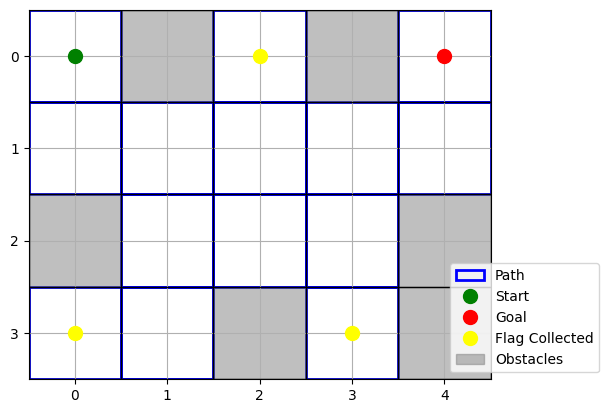

Cumulative Reward: 3.0


In [4]:
# Cell 2: This code tests to see what route the robot took and visualizes in a graph the route and the cumulative reward the robot obtained

def simulate_episode(env, policy):
    state = env.reset()
    cumulative_reward = 0
    path = [env.idx2cell[state // 8]]
    flags_collected = []
    previous_flags = env.num2flag(state % 8)  # Track flags from the initial state


    while True:
        action = np.argmax(Q_table[state])  # Choose the action with the highest Q-value for the current state
        reward, next_state, done = env.step(state, action)
        current_flags = env.num2flag(state % 8)
        flags_collected.append(current_flags)
        path.append(env.idx2cell[next_state // 8])
        cumulative_reward += reward

        # Check for new flags collected
        new_flags = [curr and not prev for curr, prev in zip(current_flags, previous_flags)]
        if any(new_flags):
            print(f"New flags collected at state {state}: {new_flags}")
        previous_flags = current_flags  # Update previous flags to current

        print(f"State: {state}, Action: {action}, Reward: {reward}, Next State: {next_state}, Done: {done}")

        if done:
            break
        state = next_state

    return path, flags_collected, cumulative_reward

def plot_episode(grid_shape, path, flags_collected, obstacles, flags_positions):
    fig, ax = plt.subplots()
    # Draw grid lines
    for x in range(grid_shape[1] + 1):
        ax.axhline(x, lw=1, color='black', zorder=5)
        ax.axvline(x, lw=1, color='black', zorder=5)
    # Highlight the path
    for (y, x) in path:
        ax.add_patch(Rectangle((x, y), 1, 1, fill=None, edgecolor='blue', lw=2, label='Path' if 'Path' not in ax.get_legend_handles_labels()[1] else ""))
    # Mark the start and goal
    ax.plot(path[0][1] + 0.5, path[0][0] + 0.5, 'go', markersize=10, label='Start' if 'Start' not in ax.get_legend_handles_labels()[1] else "")
    ax.plot(path[-1][1] + 0.5, path[-1][0] + 0.5, 'ro', markersize=10, label='Goal' if 'Goal' not in ax.get_legend_handles_labels()[1] else "")
    # Mark flags
    for (y, x) in flags_positions:
        if (y, x) in path:
            idx = path.index((y, x))
            flag_collected = any(flags_collected[idx])
            color = 'yellow' if flag_collected else 'gray'
            label = 'Flag Collected' if flag_collected else 'Flag Missed'
        else:
            color = 'gray'
            label = 'Flag Missed'
        ax.plot(x + 0.5, y + 0.5, 'o', color=color, markersize=10, label=label if label not in ax.get_legend_handles_labels()[1] else "")
    # Draw obstacles
    for (y, x) in obstacles:
        ax.add_patch(Rectangle((x, y), 1, 1, fill=True, color='gray', alpha=0.5, label='Obstacles' if 'Obstacles' not in ax.get_legend_handles_labels()[1] else ""))
    ax.set_xlim(0, grid_shape[1])
    ax.set_ylim(0, grid_shape[0])
    ax.set_aspect('equal')
    ax.invert_yaxis()
    plt.xticks(np.arange(0.5, grid_shape[1]), np.arange(grid_shape[1]))
    plt.yticks(np.arange(0.5, grid_shape[0]), np.arange(grid_shape[0]))
    plt.grid(True)
    # Place the legend outside the plot
    plt.legend(loc='lower right', bbox_to_anchor=(1.25, 0))
    plt.show()

env = Maze()
# Q_table = np.load('/Volumes/Sargart/CornellTechWork/IntelAutoSys/Intelligent-Autonomous-System/Project4/Optimal_Q_table.npy')
path, flags_collected, reward = simulate_episode(env, Q_table)
plot_episode((4, 5), path, flags_collected, env.obstacles, [(0, 2), (3, 0), (3, 3)])
print("Cumulative Reward:", reward)


# Q-learning

Step: 0, Average Steps: 100.0, Average Reward: 0.0, RMSE: 6.096608630267966
Step: 50, Average Steps: 14.5, Average Reward: 2.0, RMSE: 5.893587871570095
Step: 100, Average Steps: 15.7, Average Reward: 2.0, RMSE: 5.788079836780348
Step: 150, Average Steps: 14.7, Average Reward: 2.0, RMSE: 5.7786706801765835
Step: 200, Average Steps: 15.9, Average Reward: 2.0, RMSE: 5.776125309581237
Step: 250, Average Steps: 15.1, Average Reward: 2.0, RMSE: 5.772151418094148
Step: 300, Average Steps: 14.6, Average Reward: 2.0, RMSE: 5.7689950781977535
Step: 350, Average Steps: 13.8, Average Reward: 2.0, RMSE: 5.768798541986744
Step: 400, Average Steps: 14.3, Average Reward: 2.0, RMSE: 5.770693818573473
Step: 450, Average Steps: 14.8, Average Reward: 2.0, RMSE: 5.769599212489545
Step: 500, Average Steps: 13.9, Average Reward: 2.0, RMSE: 5.769585856677906
Step: 550, Average Steps: 14.9, Average Reward: 2.0, RMSE: 5.769725296086969
Step: 600, Average Steps: 14.0, Average Reward: 2.0, RMSE: 5.7694000829188
S

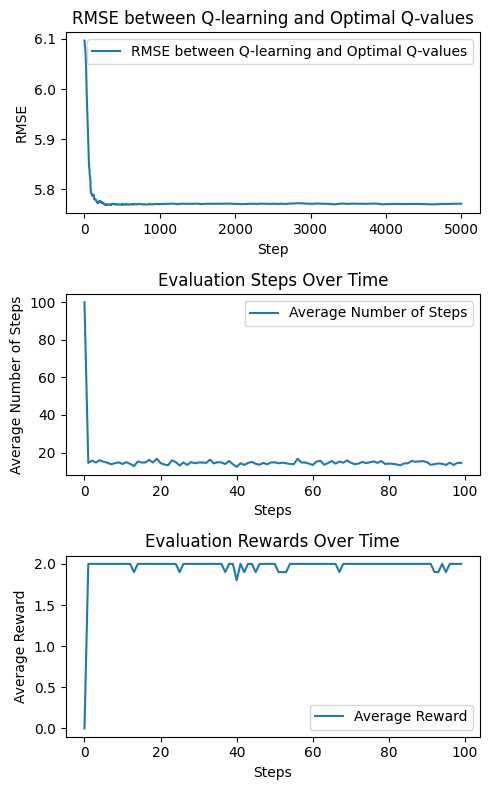

In [11]:
# Cell 3: 

# Initialize the environment
env = Maze()

# Q-learning parameters
initial_epsilon = 1.0  # Start with exploration
epsilon_decay = 0.995  # Decay rate for epsilon
min_epsilon = 0.01     # Minimum epsilon
initial_learning_rate = 0.5  # Start learning rate
learning_rate_decay = 0.999  # Decay rate for learning rate
min_learning_rate = 0.1      # Minimum learning rate
discount_factor = 0.9  # Discount factor
total_steps = 5000
evaluate_every = 50

# Initialize Q-table
Q_table = np.zeros((env.snum, env.anum))

# Storage for learning monitoring
eval_steps, eval_rewards, rms_errors = [], [], []


# Optimal Q-table for RMSE calculation
optimal_Q = np.load('Optimal_Q_table.npy')  

epsilon = initial_epsilon
learning_rate = initial_learning_rate

# Learning loop
for step in range(total_steps):
    state = env.reset()
    done = False
    total_reward = 0
    while not done:
        if np.random.rand() < epsilon:
            action = np.random.randint(0, env.anum)  # Explore
        else:
            action = np.argmax(Q_table[state])  # Exploit

        reward, next_state, done = env.step(state, action)
        total_reward += reward

        # Update Q-table using the Q-learning algorithm
        best_future_q = np.max(Q_table[next_state])
        Q_table[state][action] += learning_rate * (reward + discount_factor * best_future_q - Q_table[state][action])
        state = next_state

    # Decay epsilon and learning rate
    epsilon = max(min_epsilon, epsilon * epsilon_decay)
    learning_rate = max(min_learning_rate, learning_rate * learning_rate_decay)

    # Compute RMSE between current Q-values and the optimal Q-values
    rmse = np.sqrt(np.mean((Q_table - optimal_Q)**2))
    rms_errors.append(rmse)

    # Periodic evaluation
    if step % evaluate_every == 0:
        avg_step, avg_reward = evaluation(env, Q_table, 100, 10)
        eval_steps.append(avg_step)
        eval_rewards.append(avg_reward)
        print(f"Step: {step}, Average Steps: {avg_step}, Average Reward: {avg_reward}, RMSE: {rmse}")


# Plot all three metrics in a single figure with subplots
fig, axs = plt.subplots(3, 1, figsize=(5, 8))  # Adjust the figsize as needed

# Plot RMSE
axs[0].plot(rms_errors, label='RMSE between Q-learning and Optimal Q-values')
axs[0].set_title('RMSE between Q-learning and Optimal Q-values')
axs[0].set_xlabel('Step')
axs[0].set_ylabel('RMSE')
axs[0].legend()

# Plot Evaluation Steps
axs[1].plot(eval_steps, label='Average Number of Steps')
axs[1].set_title('Evaluation Steps Over Time')
axs[1].set_xlabel('Steps')
axs[1].set_ylabel('Average Number of Steps')
axs[1].legend()

# Plot Evaluation Rewards
axs[2].plot(eval_rewards, label='Average Reward')
axs[2].set_title('Evaluation Rewards Over Time')
axs[2].set_xlabel('Steps')
axs[2].set_ylabel('Average Reward')
axs[2].legend()

plt.tight_layout()
plt.show()


# Continuous State Space Problems

**Notes from Office Hours for part 3** 

- pi is a Stochastic policy
- Stochastic policy is a function 
- input: Current state S (pos, velocity) 
- output: 3 probabilities
    p(o) = 90 %
    p(l) = 0 % 
    p(s) = 10 %

/var/folders/7t/74m2tbsx1md6bkcpgf8d6r700000gn/T/ipykernel_24598/635078087.py:39: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  state_tensor = torch.tensor([state], dtype=torch.float32)


Episode 0	Last length: 500	Total reward: -500.00
Episode 50	Last length: 500	Total reward: -500.00
Episode 100	Last length: 269	Total reward: -268.00
Episode 150	Last length: 500	Total reward: -500.00
Episode 200	Last length: 233	Total reward: -232.00
Episode 250	Last length: 197	Total reward: -196.00
Episode 300	Last length: 161	Total reward: -160.00
Episode 350	Last length: 168	Total reward: -167.00
Episode 400	Last length: 193	Total reward: -192.00
Episode 450	Last length: 196	Total reward: -195.00
Episode 500	Last length: 137	Total reward: -136.00
Episode 550	Last length: 154	Total reward: -153.00
Episode 600	Last length: 122	Total reward: -121.00
Episode 650	Last length: 95	Total reward: -94.00
Episode 700	Last length: 83	Total reward: -82.00
Episode 750	Last length: 133	Total reward: -132.00
Episode 800	Last length: 94	Total reward: -93.00
Episode 850	Last length: 98	Total reward: -97.00
Episode 900	Last length: 99	Total reward: -98.00
Episode 950	Last length: 78	Total reward: -7

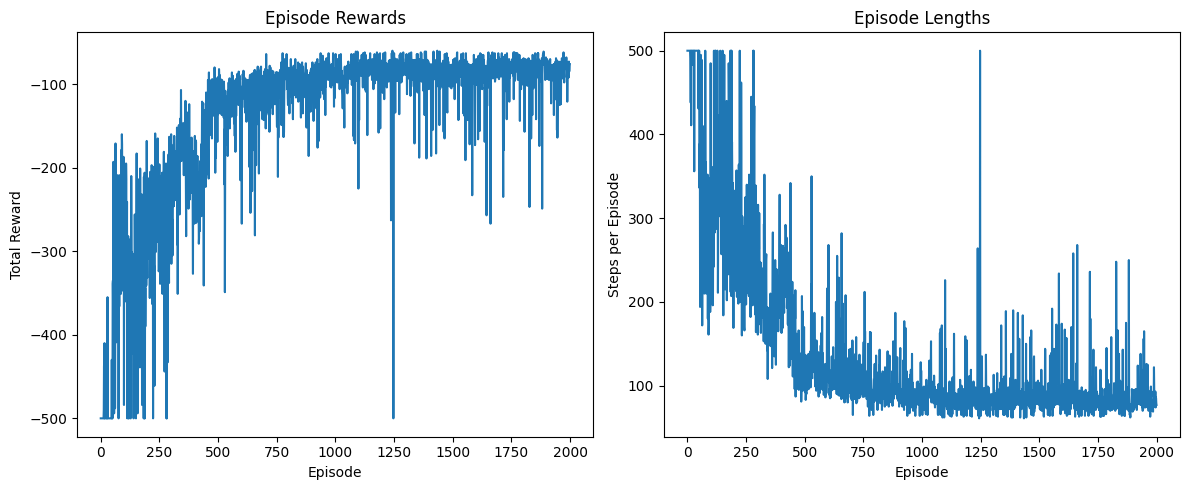

In [6]:
# Cell 4: Applying REINFORCE for Acrobot-v1


class PolicyNet(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 16)
        self.fc2 = nn.Linear(16, n_outputs)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=-1)
        return x

def discount_rewards(rewards, gamma=0.99):
    discounted = np.zeros_like(rewards)
    R = 0
    for t in reversed(range(len(rewards))):
        R = R * gamma + rewards[t]
        discounted[t] = R
    return discounted

def reinforce(env, policy_net, episodes, gamma=0.99, max_steps_per_episode=500):
    optimizer = optim.Adam(policy_net.parameters(), lr=0.01)
    episode_rewards = []
    episode_lengths = []

    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]

        log_probs = []
        rewards = []
        done = False
        steps = 0

        while not done and steps < max_steps_per_episode:
            state_tensor = torch.tensor([state], dtype=torch.float32)
            probs = policy_net(state_tensor)
            action = np.random.choice(env.action_space.n, p=probs.detach().numpy()[0])

            result = env.step(action)
            # Adjusted to handle an extra False value in the tuple
            if isinstance(result, tuple) and len(result) >= 4:
                state, reward, done, _ = result[0], result[1], result[2], result[3]
            else:
                print("Debug: Unexpected result from env.step(action):", result)
                raise ValueError("Unexpected result format from environment step")

            log_prob = torch.log(probs.squeeze(0)[action])
            log_probs.append(log_prob)
            rewards.append(reward)
            steps += 1

        episode_rewards.append(sum(rewards))
        episode_lengths.append(steps)

        discounted_rewards = discount_rewards(rewards, gamma)
        discounted_rewards = torch.tensor(discounted_rewards, dtype=torch.float32)

        policy_gradient = []
        for log_prob, Gt in zip(log_probs, discounted_rewards):
            policy_gradient.append(-log_prob * Gt)

        optimizer.zero_grad()
        policy_gradient = torch.stack(policy_gradient).sum()
        policy_gradient.backward()
        optimizer.step()

        if episode % 50 == 0 or episode == episodes - 1:
            print(f'Episode {episode}\tLast length: {steps}\tTotal reward: {sum(rewards):.2f}')

    return episode_rewards, episode_lengths



# Setup environment and network
env = gym.make('Acrobot-v1')
policy_net = PolicyNet(env.observation_space.shape[0], env.action_space.n)

# Train the model and capture the episode data for plotting
episode_rewards, episode_lengths = reinforce(env, policy_net, episodes=2000)

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(episode_rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')

plt.subplot(1, 2, 2)
plt.plot(episode_lengths)
plt.title('Episode Lengths')
plt.xlabel('Episode')
plt.ylabel('Steps per Episode')
plt.tight_layout()
plt.show()





In [12]:
# Cell 5: This displays the animation of Acrobot 
# WARNING: This window wont close by itself so you need to stop the code running here and force quit the pygame window

# Setup environment and network
env = gym.make('Acrobot-v1', render_mode="human")
policy_net = PolicyNet(env.observation_space.shape[0], env.action_space.n)

# Train the model and display it with the built in animation
episode_rewards, episode_lengths = reinforce(env, policy_net, episodes=2000)

env.close()

Episode 0	Last length: 271	Total reward: -270.00


KeyboardInterrupt: 

Episode 0, Total Reward: -21684.0
Episode 100, Total Reward: -478.0
Episode 200, Total Reward: -429.0
Episode 300, Total Reward: -238.0
Episode 400, Total Reward: -422.0
Episode 500, Total Reward: -397.0
Episode 600, Total Reward: -287.0
Episode 700, Total Reward: -222.0
Episode 800, Total Reward: -231.0
Episode 900, Total Reward: -191.0
Episode 1000, Total Reward: -245.0
Episode 1100, Total Reward: -814.0
Episode 1200, Total Reward: -199.0
Episode 1300, Total Reward: -254.0
Episode 1400, Total Reward: -270.0
Episode 1500, Total Reward: -191.0
Episode 1600, Total Reward: -302.0
Episode 1700, Total Reward: -237.0
Episode 1800, Total Reward: -276.0
Episode 1900, Total Reward: -233.0
Episode 2000, Total Reward: -189.0
Episode 2100, Total Reward: -243.0
Episode 2200, Total Reward: -241.0
Episode 2300, Total Reward: -259.0
Episode 2400, Total Reward: -195.0
Episode 2500, Total Reward: -166.0
Episode 2600, Total Reward: -244.0
Episode 2700, Total Reward: -184.0
Episode 2800, Total Reward: -1

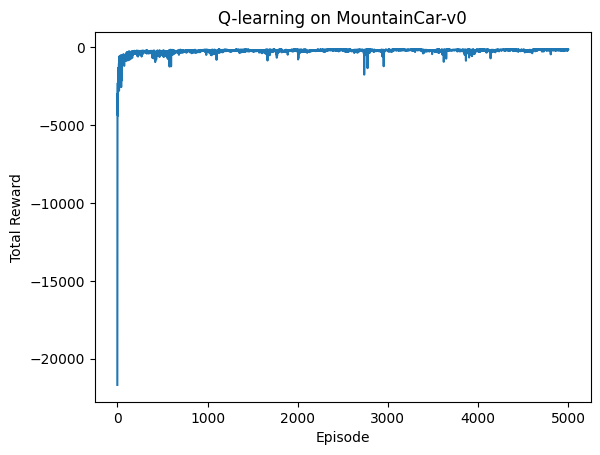

In [7]:
# Cell 6: Applies Q-learning for MountainCar

def create_bins(low, high, num_bins):
    """ Create bins for discretization based on low and high values of state variables. """
    return np.linspace(low, high, num_bins + 1)[1:-1]

def discretize_state(state, bins):
    """Discretize the continuous state space into indices based on bins."""
    # Adjust to handle the state correctly if it's part of a tuple
    if isinstance(state, tuple):
        state = state[0]  # Assuming the first element is the state array
    return tuple(np.digitize(state[dim], bins[dim]) - 1 for dim in range(len(state)))


def initialize_q_table(bins, action_space):
    """ Initialize Q-table with an extra bin for each state dimension plus the action space size. """
    num_states = [len(bin) + 1 for bin in bins]
    return np.zeros(shape=tuple(num_states) + (action_space.n,), dtype=float)

def choose_action(state, q_table, epsilon, episode, num_episodes):
    decay_rate = 0.995  # Slow down the decay a little
    min_epsilon = 0.1   # Ensure some level of exploration throughout
    if episode % 100 == 0:  # Adjust epsilon less aggressively
        epsilon = max(min_epsilon, epsilon * decay_rate)
    else:
        epsilon = max(min_epsilon, epsilon * decay_rate ** (1 / 30))  # Gradual decay

    if np.random.random() < epsilon:
        return np.random.randint(0, len(q_table[state]))
    else:
        return np.argmax(q_table[state])

def update_q_table(q_table, state, action, reward, next_state, alpha, gamma):
    current_q = q_table[state][action]
    max_future_q = np.max(q_table[next_state])
    learning_rate = alpha
    if next_state[0] > state[0]:  # Encourage moving towards the goal
        learning_rate *= 2

    new_q = (1 - learning_rate) * current_q + learning_rate * (reward + gamma * max_future_q)
    q_table[state][action] = new_q

def q_learning(env, num_episodes, alpha, gamma, initial_epsilon, bins):
    q_table = initialize_q_table(bins, env.action_space)
    rewards = []
    epsilon = initial_epsilon

    for episode in range(num_episodes):
        state = discretize_state(env.reset(), bins)
        episode_reward = 0

        done = False
        while not done:
            action = choose_action(state, q_table, epsilon, episode, num_episodes)
            next_state_raw, reward, done, reached_goal, _ = env.step(action)

            if next_state_raw[0] > state[0]:  # Moving right
                reward += 10 * (next_state_raw[0] + 1.2)  # Incremental reward for moving towards the flag

            if next_state_raw[1] > 0 and next_state_raw[0] > state[0]:  # Positive velocity towards the flag
                reward += 5 * next_state_raw[1]  # Smaller reward for positive velocity

            next_state = discretize_state(next_state_raw, bins)
            update_q_table(q_table, state, action, reward, next_state, alpha, gamma)

            state = next_state
            episode_reward += reward

        rewards.append(episode_reward)
        if episode % 100 == 0:
            print(f"Episode {episode}, Total Reward: {episode_reward}")

    return q_table, rewards


# Environment setup
env = gym.make('MountainCar-v0')
# env = gym.make('MountainCar-v0')

position_bins = create_bins(env.observation_space.low[0], env.observation_space.high[0], 30)
velocity_bins = create_bins(env.observation_space.low[1], env.observation_space.high[1], 20)
bins = [position_bins, velocity_bins]

# Hyperparameters
alpha = 0.1    # Learning rate
gamma = 0.99   # Discount factor
epsilon = 0.1  # Exploration rate
num_episodes = 5000 

# Run Q-learning with debugging
q_table, rewards = q_learning(env, num_episodes, alpha, gamma, epsilon, bins)

# Plotting results
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-learning on MountainCar-v0')
plt.show()


In [13]:
# Cell 7: Visualizes MountainCar with animation 
# WARNING: This window wont close by itself so you need to stop the code running here and force quit the pygame window

# Environment setup
env = gym.make('MountainCar-v0', render_mode="human")
# env = gym.make('MountainCar-v0')

position_bins = create_bins(env.observation_space.low[0], env.observation_space.high[0], 30)
velocity_bins = create_bins(env.observation_space.low[1], env.observation_space.high[1], 20)
bins = [position_bins, velocity_bins]

# Hyperparameters
alpha = 0.1    # Learning rate
gamma = 0.99   # Discount factor
epsilon = 0.1  # Exploration rate
num_episodes = 5000 

# Run Q-learning with debugging
q_table, rewards = q_learning(env, num_episodes, alpha, gamma, epsilon, bins)

KeyboardInterrupt: 

: 